# Analyzing the Fairness of AP Scores

## Ekansh Vinaik, Matthew Chung

### Getting Started

If you're reading this, there's a high likelihood that you have heard of or taken a standardized test. One such organization that creates these tests is the College Board: a *self-proclaimed nonprofit* organization that claims to provide **capable** students with the ability to gain college credit for high school courses. What exactly does the word capable mean? To discover the existence of any possible definitions or biases for the capability of a student, let's analyze a [College Board provided dataset from Kaggle (2016)](https://www.kaggle.com/collegeboard/ap-scores). It provides demographic (race and gender) based data on AP scores by exam. We'll start by importing necessary modules.

In [85]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import statsmodels.formula.api as sm
import seaborn as sns
from matplotlib import gridspec

Let's load in the dataset and see what we have to work with. Though the dataset is provided directly from Kaggle and the College Board, we should be prepared to perform some **data wrangling**.

In [3]:
df = pd.read_csv('ap/exams.csv')
df.head(7)

,Exam Subject,Score,Students (11th Grade),Students (12th Grade),Students (Male),Students (Female),Students (White),Students (Black),Students (Hispanic/Latino),Students (Asian),Students (American Indian/Alaska Native),Students (Native Hawaiian/Pacific Islander),Students (Two or More Races),All Students (2016)
0,ART HISTORY,5,897.00,1260.00,815.00,1889.00,1631.00,34,321.00,514.00,5,5,154.00,2704.00
1,ART HISTORY,4,1835.00,2608.00,1800.00,3787.00,3290.00,132,918.00,877.00,13,8,273.00,5587.00
2,ART HISTORY,3,2311.00,3282.00,2283.00,4657.00,3898.00,287,1347.00,992.00,19,10,307.00,6940.00
3,ART HISTORY,2,2252.00,3248.00,2374.00,4494.00,3211.00,450,1972.00,809.00,15,21,280.00,6868.00
4,ART HISTORY,1,901.00,1352.00,1072.00,1699.00,942.00,307,1074.00,292.00,13,10,87.00,2771.00
5,ART HISTORY,All,8196.00,11750.00,8344.00,16526.00,12972.00,1210,5632.00,3484.00,65,54,1101.00,24870.00
6,ART HISTORY,Average,2.95,2.93,2.87,2.98,3.11,2.29,2.55,3.15,2.72,2.57,3.12,2.94


### Data Wrangling

Unfortunately, it seems like our data is not in a suitable format. We want to simplify the data as much as possible into separate observations.

Let's start by melting the columns so that the race is an observation rather than a label. We'll also rename the columns to be easier to use. Finally, convert the AP scores and their counts to numeric values and drop any rows that are missing values, as these will only include rows with non numeric scores.

In [4]:
df = pd.melt(df, id_vars=['Exam Subject', 'Score'], var_name='group')
df.columns = ['exam', 'score', 'group', 'count']
df['group'] = df['group'].str.extract(r"\((.*?)\)", expand=False)
df['score'] = pd.to_numeric(df['score'], errors='coerce')
df['count'] = pd.to_numeric(df['count'], errors='coerce')
df.dropna(inplace=True)

If we consider how many AP exams exist and the number of groups, we'll find that analyzing scores by both exam topic and group will be tedious, lengthy, and unlikely to be more informative than analyzing exam scores with respect to demographic only. Instead, let's group exams by STEM or Humanities as these are common divides between subjects. We'll use the [definition of STEM from the College Board](https://apcentral.collegeboard.org/courses).

In [5]:
stem = ['BIOLOGY', 'CALCULUS AB', 'CALCULUS BC', 'CHEMISTRY',
        'COMPUTER SCIENCE A', 'ENVIRONMENTAL SCIENCE',
        'PHYSICS C: ELECTRICITY & MAGNETISM', 'PHYSICS C: MECHANICS',
        'PHYSICS 1', 'PHYSICS 2', 'STATISTICS']
df['stem'] = df['exam'].isin(stem)
df.drop('exam', inplace=True, axis=1)
df = df.groupby(['group', 'stem', 'score']).sum().reset_index()

The last step in our data wrangling pipeline will be to use an alternative to raw counts. Because raw counts are less useful in comparing data with different total counts, we'll use a proportion instead. To do so, let's calculate the ratio of students who get each score in each demographic for both STEM and non STEM.

In [6]:
def weighted_avg_and_std(values, weights):
    average = np.average(values, weights=weights)
    variance = np.average((values-average)**2, weights=weights)
    return (average, variance)

In [7]:
df['ratio'] = df.groupby(['group', 'stem'])['count'].transform(lambda grp: grp / grp.sum())
df.head()

,group,stem,score,count,ratio
0,11th Grade,False,1.0,209441.0,0.166913
1,11th Grade,False,2.0,320055.0,0.255067
2,11th Grade,False,3.0,315632.0,0.251542
3,11th Grade,False,4.0,246087.0,0.196118
4,11th Grade,False,5.0,163574.0,0.130360


Now that we have a clean DataFrame, we can move to the next step of the data analysis timeline.

### Exploratory Analysis and Data Visualization

The next step in the data analysis process is to perform some exploratory data analysis (EDA) to discover and unearth relationships or phenomena that are not always immediately obvious. Our dataset provides us with demographic information, so we'll primarily look at the effect that certain demographics have on AP Exam performance. To get an idea of what the distribution might ideally look like, let's plot the distribution of all scores in 2016 with respect to only STEM or Humanities and the scores.

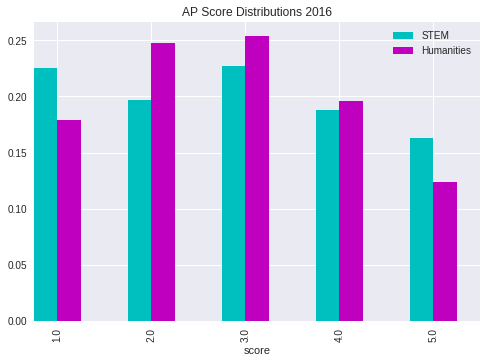

In [11]:
fig = plt.figure()
ax = fig.add_subplot(111)
df[(df.stem == True) & (df.group == '2016')].plot.bar(
    x='score', y='ratio', label='STEM', color='c', ax=ax, position=1, width=.25)
df[(df.stem == False) & (df.group == '2016')].plot.bar(
    x='score', y='ratio', label='Humanities', color='m', ax=ax, position=0, width=.25)
ax.set_title('AP Score Distributions 2016')

plt.show()

#### Gender

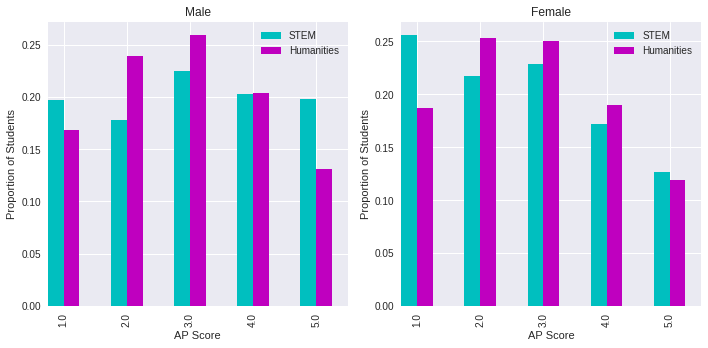

In [148]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

for gender in ['Male', 'Female']:
    ax = axes[1 if len(gender) > 4 else 0]
    temp = df[df['group'] == gender]
    
    temp[temp.stem][['score', 'ratio']].plot.bar(x='score', color='c', ax=ax, position=1, width=.25)
    temp[temp.stem == False][['score', 'ratio']].plot.bar(x='score', color='m', ax=ax, position=0, width=.25)
    ax.set_xlabel('AP Score')
    ax.set_ylabel('Proportion of Students')
    ax.set_title(gender)
    ax.legend(['STEM', 'Humanities'])

fig.tight_layout()
plt.show()

#### Race

Now, take a look at racial demographics. Below, we generate box plots of each group's AP scores grouped by STEM vs. non STEM. Immediately, there are clear trends noticed for each demographic:

| Demographic | Analysis |
| ----------- | :-------- |
| American Indian/Alaska Native | large left skew |
| Asian | large right skew |
| Black | large left skew |
| Hispanic/Latino | large left skew |
| Native Hawaiian/Pacific Islander | large left skew |
| Two or More Races | close to normal, some left skew |
| White | close to normal, some right skew |

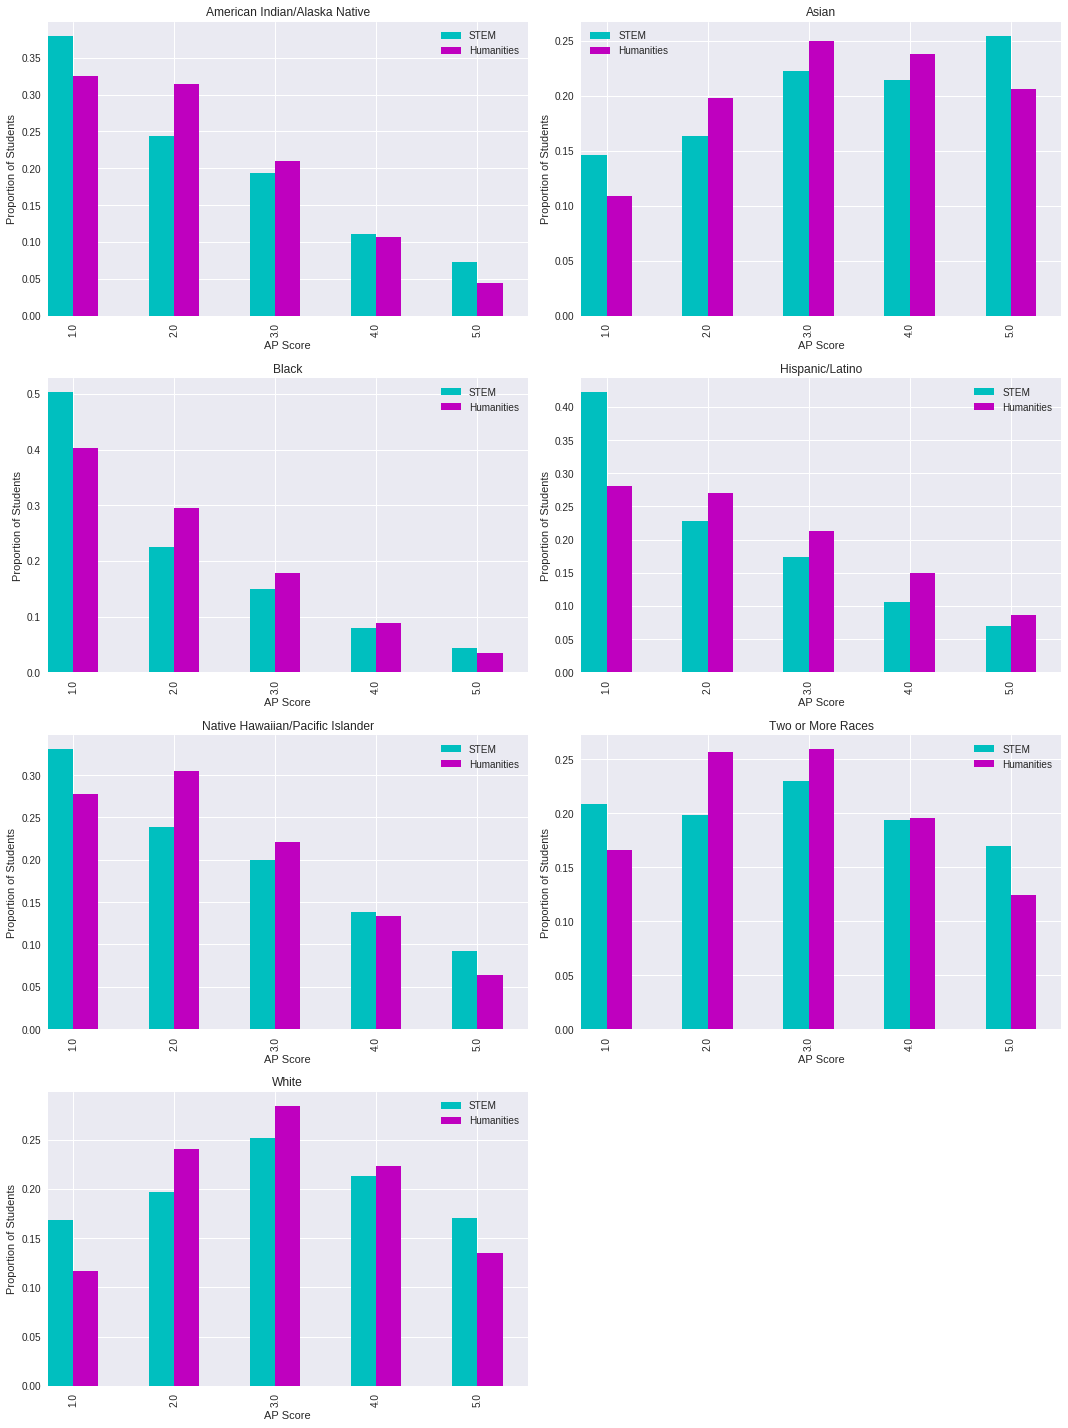

In [20]:
races = ['American Indian/Alaska Native', 'Asian', 'Black',
         'Hispanic/Latino','Native Hawaiian/Pacific Islander',
         'Two or More Races', 'White']

N = len(races)
gs = gridspec.GridSpec(4, 2)
fig = plt.figure(figsize=(15, 20))

for i in range(N):
    temp = df[df['group'] == races[i]]
    ax = fig.add_subplot(gs[i])
    
    temp[temp.stem][['score', 'ratio']].plot.bar(x='score', color='c', ax=ax, position=1, width=.25)
    temp[temp.stem == False][['score', 'ratio']].plot.bar(x='score', color='m', ax=ax, position=0, width=.25)
    ax.set_xlabel('AP Score')
    ax.set_ylabel('Proportion of Students')
    ax.set_title(races[i])
    ax.legend(['STEM', 'Humanities'])

fig.tight_layout()
plt.show()

In [135]:
avgs = pd.DataFrame()
for title, group in df.groupby(['group', 'stem']):
    x = group['score'] * group['ratio']
    avgs = avgs.append({'group': title[0], 'stem': bool(title[1]), 'score': x.sum()}, ignore_index=True)

avgs['stem'] = avgs['stem'].apply(lambda x: x == 1)

In [136]:
res = sm.ols(formula='score ~ group', data=avgs).fit()
out = pd.DataFrame()
out['coefficient'], out['pval'] = res.params, res.pvalues
out.index = avgs.group.unique()
out.iloc[1:] = out.iloc[1:] + out.iloc[0]
out.reset_index(inplace=True)
out.columns = ['group', 'coefficient', 'pval']
out[out.pval < .05]

,group,coefficient,pval
0,11th Grade,2.877824,2.218045e-15
3,American Indian/Alaska Native,2.241521,4.041875e-06
4,Asian,3.250795,5.545172e-04
5,Black,1.997390,1.278021e-07
7,Hispanic/Latino,2.331935,1.862938e-05
9,Native Hawaiian/Pacific Islander,2.412156,8.297738e-05
